# Run Data Assimilation (Individual Seasonality)

In this notebook, we will run the data assimilation (DA) that will get us from data to reconstruction. The goal is to use _cfr_'s codebase with no edits to make updates on LMRv2.1 [Tardif et al. 2019](https://cp.copernicus.org/articles/15/1251/2019/) using the [PReSto2k](https://paleopresto.github.io/) Proxy Database. 

## Author
[Tanaya Gondhalekar](https://orcid.org/0009-0004-2440-3266)

⚠️ **Warning** 

This notebook cannot be run locally! The process is run on USC's Center for Advanced Research Computing ([CARC](https://www.carc.usc.edu)) HPC Servers. The specifications used will be provided in the shell file below.

### shell file for CARC

```bash
#!/bin/bash

#SBATCH --partition=main
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=32G
#SBATCH --time=40:00:00

module purge
eval "$(conda shell.bash hook)"

conda activate cfr-env

python lmr_reproduce.py
```


In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)

2025.7.28


## Load Data
The data needed to run this reconstruction comes in three parts:
- Prior: Model output climate data (CMIP5 CCSM4)
- Calibration: Instrumental climate data (temperature: GISTEMPv4, precipitation: GPCCv6)
- Proxy: Proxy data (from PAGES2k consortium)

1. Download from [here](http://www.atmos.uw.edu/~wperkins/nobackup/lmr_data/LMR_data.tar.gz)
2. Extract all relevant contents into ./prev_data/
3. **Prior** data can be found under LMR_data > data > model > ccsm4_last_millenium\
    a. Put in directory ./prev_data/ccsm4_last_millenium/ \
    b. Required:
    - pr_sfc_Amon_CCSM4_past1000_085001-185012.nc
    - tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
6. **Calibration** data can be found under LMR_data > data > analyses copy > GPCC
    - The other calibration dataset (GISTEMPv4) comes shipped with _cfr_, but GPCCv6 does not. 
7. **Proxy** data ([PReSto2k](https://paleopresto.github.io/)) will come from the LiPDVerse or LiPDGraph notebooks. 

### Load proxies

This comes from _Assembling the Proxy Database from the LiPDVerse_ , where the data is accessed through the LipDGraph and processed to fit the format of _cfr_'s ```ProxyDatabase``` Class.\
\
```load_proxydb()``` takes in a .json, .pckl, or .nc file and with the given columns, very specific to _cfr_, creates a new ```ProxyDatabase``` object for our use in the reconstruction. In this specific example, we will use a NetCDF file created by afforementioned notebook. 

In [2]:
import pickle

print("Loading from pickle...")
with open('./prev_data/pdb_w_seasonality_annual.pkl', 'rb') as f:
    pickle_db = pickle.load(f)

print(f"Loaded {pickle_db.nrec} records from pickle")

Loading from pickle...
Loaded 559 records from pickle


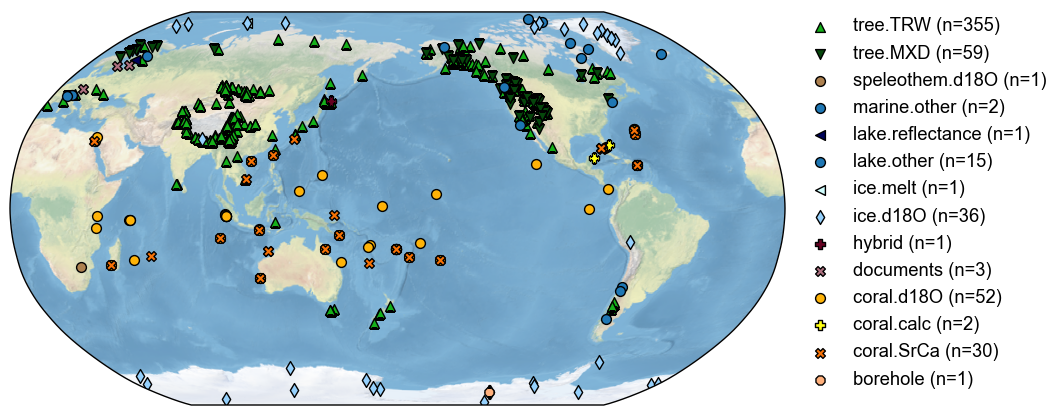

In [ ]:
# new

job = cfr.ReconJob()
job.proxydb = pickle_db

fig, ax = job.proxydb.plot(plot_count=False)

### Load model prior 

This reconstruction uses [CMIP5 CCSM4 past 1000](https://www.wdc-climate.de/WDCC/CMIP5/Compact.jsp?acronym=NRS4pk) as the model prior. This is the Coupled Model Intercomparison Project phase 5 (CMIP5) (Taylor et al., 2012) Last Millennium simulation from the Community Climate System Model version 4 (CCSM4) coupled atmosphere–ocean–sea-ice model. The simulation covers years 850 to 1850 CE and includes incoming solar variability and variable greenhouse gases, as well as stratospheric aerosols from volcanic eruptions known to have occurred during the simulation period (Tardif et al., 2019). This model prior provides the initial climate states used in the data assimilation (DA) step.\
\
```load_clim()``` loads in .nc files (or files that are shipped with the package) and formats them into ```ClimateField``` objects for use in the DA workflow.\
\
```anom_period``` refers to the climatological reference period with which to compute climate anomalies. Tardif et al. use the full interval for LMRv2.1.

In [4]:
job.load_clim(
    tag='prior',
    
    path_dict= {
    'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
    'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'
    },
    anom_period=[850,1850],  # Tardif 2019 uses entire interval
    load=True,  
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc', 'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'}
>>> job.configs["prior_anom_period"] = [850, 1850]
>>> job.configs["prior_lat_name"] = lat
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


Do a check in after loading to make sure the NetCDF file loaded in correctly. If there are any ```NaN``` values, you will be warned.

In [5]:
# Check after load
print("\nAfter initial load:")
print("Shape:", job.prior['tas'].da.shape)
print("Contains NaN?", np.any(np.isnan(job.prior['tas'].da.values)))
if not np.any(np.isnan(job.prior['tas'].da.values)):
    print("Sample values from first timestep:")
    vals = job.prior['tas'].da.isel(time=0, lat=slice(0,5), lon=slice(0,5)).values
    print(vals)


After initial load:
Shape: (12012, 192, 288)
Contains NaN? False
Sample values from first timestep:
[[ 4.2724609e-04 -1.4116669e+00 -1.4149780e+00 -7.6078796e-01
  -1.3295441e+00]
 [ 2.8004456e-01  2.4789429e-01  3.3767700e-01 -5.2047729e-02
   3.3233643e-01]
 [ 4.6669006e-01 -1.6618347e-01  5.8181763e-01 -2.5801086e-01
   2.7944946e-01]
 [ 3.3268738e-01  3.2659912e-01  3.8771057e-01  4.2834473e-01
   6.8528748e-01]
 [ 3.4626770e-01  3.5942078e-01  6.5942383e-01  1.0366669e+00
   7.7363586e-01]]


### Load calibration data

The calibration data sets used in this study are the NASA Goddard Institute for Space Studies (GISS) Surface Temperature Analysis ([GISTEMP](https://data.giss.nasa.gov/gistemp/news/2010summer/)) (Hansen et al., 2010) version 4 for temperature and the gridded precipitation data set from the Global Precipitation Climatology Centre ([GPCC](https://psl.noaa.gov/data/gridded/data.gpcc.html)) (Schneider et al., 2014) version 6 as the source of monthly information on moisture input over land surfaces (Tardif et al., 2019).\
\
```anom_period``` is restricted exclusively to the instrumental period due to observational data constraints. 

In [6]:
job.load_clim(
    tag='obs',
    path_dict={
        'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc',
        'tas': 'gistemp1200_ERSSTv4'
    },
    rename_dict={'pr': 'precip','tas': 'tempanomaly'},
    anom_period=[1951, 1980], 
    load=True,
    verbose = True
)

>>> job.configs["obs_path"] = {'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc', 'tas': 'gistemp1200_ERSSTv4'}
>>> job.configs["obs_rename_dict"] = {'pr': 'precip', 'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> The target file seems existed at: ./data/gistemp1200_ERSSTv4.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['pr', 'tas'] loaded
>>> job.obs created


## Calibrate PSMs

PSM Calibration is a crucial step in the DA process because it defines a quantitative relationship between our observational data and the climate. Since proxies don't directly record climate variables (e.g.,temperature, precipitation), PSM calibration translates the climate variable from instrumental measurements into proxy variables (e.g., d18O, Mg/Ca). This makes sure that the proxy information is on the same scale as the prior climate state, allowing the DA algorithm to correctly weight and blend proxy data with model output. Without proper calibration, we risk introducing biases or inconsistencies between proxies and the prior, which can add error to the reconstruction. \
\
The first step is to create a dictionary between the proxy archive type and the type of calibration equation used. We also create a dictionary for which climate variable needs to be used for each proxy. For most in LMRv2.1, the calibration equation is linear univariate, with the exception being Tree Ring Width (TRW) which is bilinear, with temperature and precipitation used as inputs.\
\
Instead of using a pre-defined dictionary for proxy seasonal growth, this workflow uses the seasonality stored in each record’s metadata already converted to a list of calendar months so each proxy is calibrated using its own optimal growth period. This allows the PSM to reflect the actual seasonal sensitivity of each record. If calibration with the metadata seasonality fails, the code falls back to using an annual seasonality.
\
After calibration, each successfully calibrated record is tagged as 'calibrated', and its observation-error variance (R) is set from the PSM’s mean squared error (PSMmse). This value is then used by the DA algorithm to weight proxy information relative to the prior during assimilation.

```calib_psms``` does what was described above. It takes in the observational proxy data and calibrates it using instrumental climate data to get a best fit regression.

In [ ]:
# Instead of using the built-in calib_psms, create a custom calibration loop
# that uses individual proxy seasonality

import cfr.psm as psm
from tqdm import tqdm

def calib_psms_seasonality(job, ptype_psm_dict, ptype_clim_dict, 
                                        calib_period=[1850, 2015], verbose=True):
   """
   Calibrate proxy system models (PSMs) using individual proxy seasonality metadata.
   
   This function calibrates PSMs for each proxy record in the database using the 
   seasonality information stored in each proxy's metadata, rather than applying
   uniform seasonality across proxy types. This approach allows for more accurate
   proxy modeling by respecting the individual seasonal response characteristics
   of each proxy record.
   
   Parameters
   ----------
   job : cfr.ReconJob
       A ReconJob object containing the proxy database and observational climate data.
       Must have job.proxydb (ProxyDatabase) and job.obs (dict of ClimateField objects).
   ptype_psm_dict : dict
       Dictionary mapping proxy types to PSM class names. 
       Example: {'coral.d18O': 'Linear', 'tree.TRW': 'Bilinear'}
   ptype_clim_dict : dict  
       Dictionary mapping proxy types to lists of required climate variables.
       Example: {'coral.d18O': ['tas'], 'tree.TRW': ['tas', 'pr']}
   calib_period : list of int, optional
       Two-element list specifying the calibration period [start_year, end_year].
       Default is [1850, 2015].
   verbose : bool, optional
       If True, print calibration progress and summary statistics. Default is True.
       
   Returns
   -------
   None
       Modifies the job.proxydb in place by adding calibrated PSM objects to each
       proxy record and tagging successfully calibrated records.
    """
    
    for pid, pobj in tqdm(job.proxydb.records.items(), total=job.proxydb.nrec, 
                         desc='Calibrating PSMs with metadata seasonality'):
        
        psm_name = ptype_psm_dict[pobj.ptype]
        
        # Get climate data for this proxy
        for vn in ptype_clim_dict[pobj.ptype]:
            if 'clim' not in pobj.__dict__ or f'obs.{vn}' not in pobj.clim:
                pobj.get_clim(job.obs[vn], tag='obs')
        
        # Create PSM object
        pobj.psm = psm.__dict__[psm_name](pobj, climate_required=ptype_clim_dict[pobj.ptype])
        
        # Use individual proxy seasonality from metadata
        proxy_seasonality = pobj.seasonality
        
        # Calibrate based on PSM type
        if psm_name == 'Bilinear':
            try:
                pobj.psm.calibrate(
                    season_list1=[proxy_seasonality],  # Use proxy's own seasonality
                    season_list2=[proxy_seasonality],  # Use proxy's own seasonality  
                    calib_period=calib_period
                )
            except:  
                pobj.psm.calibrate(
                season_list1=[list(range(1,13))],
                season_list2=[list(range(1,13))],
                calib_period=calib_period
        )

        else:
            try:
                pobj.psm.calibrate(
                    season_list=[proxy_seasonality],   # Use proxy's own seasonality
                    calib_period=calib_period
                )
            except:
                pobj.psm.calibrate(
                season_list=[list(range(1,13))],
                calib_period=calib_period
                )

    
    # Tag calibrated records
    for pid, pobj in job.proxydb.records.items():
        if pobj.psm.calib_details is None:
            if verbose: print(f'>>> PSM for {pid} failed to be calibrated.')
        else:
            job.proxydb.records[pid].tags.add('calibrated')
            job.proxydb.records[pid].R = pobj.psm.calib_details['PSMmse']
    
    if verbose:
        calibrated_count = job.proxydb.nrec_tags("calibrated")
        print(f'>>> {calibrated_count} records tagged "calibrated" with ProxyRecord.psm created')

In [8]:
# PSM to be used
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'coral.calc': 'Linear',
    'ice.d18O': 'Linear',
    'ice.melt': 'Linear',
    'lake.other': 'Linear',
    'lake.reflectance': 'Linear',
    'speleothem.d18O' : 'Linear',
    'sclerosponge.d18O': 'Linear',
    'marine.other': 'Linear',
    'borehole': 'Linear',
    'hybrid': 'Linear',
    'documents': 'Linear',
}


ptype_clim_dict = {
    'tree.TRW': ['tas', 'pr'],
    'tree.MXD': ['tas'],
    'coral.d18O': ['tas'],
    'coral.SrCa': ['tas'],
    'coral.calc': ['tas'],
    'ice.d18O': ['tas'],
    'ice.melt': ['tas'],
    'lake.other': ['tas'],
    'lake.reflectance': ['tas'],
    'speleothem.d18O' : ['tas'],
    'sclerosponge.d18O': ['tas'],
    'marine.other': ['tas'],
    'borehole': ['tas'],
    'hybrid': ['tas'],
    'documents': ['tas'],
}

When the PSMs are calibrating, you will notice it skips those that dont have the number of overlapped data points being < 25. This is a default parameter set to 25 that you can change in `job.calibrate` called `nobs_lb`. The default, set by Tardif et al. 2019 was set to require at least 25 years of non-contiguous overlap with calibration data as a minimum. Within the function, if nobs  < nobs_lb (fewer than 25 overlapping points between observational data and climate data), the calibration is skipped because there isn't enough data to establish a reliable statistical relationship between the proxy and climate variables.

In [ ]:
# Use the custom function
calib_psms_seasonality(
    job, 
    ptype_psm_dict=ptype_psm_dict,
    ptype_clim_dict=ptype_clim_dict,
    verbose=True
)

Calibrating PSMs with metadata seasonality:   3%|▎         | 19/559 [00:01<00:37, 14.51it/s]

Asia_117 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...


Calibrating PSMs with metadata seasonality:   4%|▍         | 21/559 [00:03<02:53,  3.10it/s]

Asia_117 >>> Found nearest climate within distance of 1 deg.


Calibrating PSMs with metadata seasonality:   5%|▌         | 29/559 [00:03<01:07,  7.84it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:   6%|▋         | 35/559 [00:04<00:46, 11.18it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:   7%|▋         | 37/559 [00:04<00:42, 12.38it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:   8%|▊         | 42/559 [00:04<00:37, 13.91it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  11%|█▏        | 64/559 [00:05<00:29, 16.96it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  13%|█▎        | 75/559 [00:06<00:29, 16.28it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  14%|█▍        | 81/559 [00:06<00:29, 16.24it/s]

The number of overlapped data points is 2 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  18%|█▊        | 100/559 [00:08<00:28, 15.86it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  20%|██        | 114/559 [00:09<00:32, 13.65it/s]

Asia_118 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...


Calibrating PSMs with metadata seasonality:  21%|██        | 116/559 [00:11<02:18,  3.21it/s]

Asia_118 >>> Found nearest climate within distance of 1 deg.


Calibrating PSMs with metadata seasonality:  26%|██▌       | 144/559 [00:13<00:27, 15.16it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  30%|███       | 168/559 [00:14<00:24, 16.23it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  37%|███▋      | 206/559 [00:16<00:22, 15.81it/s]

Asia_111 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...


Calibrating PSMs with metadata seasonality:  37%|███▋      | 208/559 [00:18<01:51,  3.14it/s]

Asia_111 >>> Found nearest climate within distance of 1 deg.


Calibrating PSMs with metadata seasonality:  43%|████▎     | 243/559 [00:21<00:20, 15.43it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  47%|████▋     | 263/559 [00:22<00:18, 15.93it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  48%|████▊     | 267/559 [00:22<00:18, 16.06it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  50%|████▉     | 279/559 [00:23<00:16, 17.30it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  52%|█████▏    | 292/559 [00:24<00:15, 17.60it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  57%|█████▋    | 318/559 [00:25<00:15, 16.02it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  65%|██████▌   | 365/559 [00:28<00:11, 16.48it/s]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  68%|██████▊   | 381/559 [00:29<00:10, 16.60it/s]

Asia_119 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asia_119 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...


Calibrating PSMs with metadata seasonality:  69%|██████▉   | 385/559 [00:33<01:07,  2.57it/s]

Asia_119 >>> Found nearest climate within distance of 2 deg.


Calibrating PSMs with metadata seasonality:  72%|███████▏  | 403/559 [00:34<00:12, 12.64it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  75%|███████▍  | 418/559 [00:35<00:08, 16.73it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  80%|███████▉  | 445/559 [00:36<00:06, 16.96it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  89%|████████▉ | 497/559 [00:40<00:03, 15.76it/s]

The number of overlapped data points is 17 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  90%|████████▉ | 501/559 [00:40<00:03, 16.68it/s]

The number of overlapped data points is 13 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  92%|█████████▏| 512/559 [00:41<00:02, 17.56it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  93%|█████████▎| 521/559 [00:41<00:02, 18.12it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 16 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  94%|█████████▍| 527/559 [00:42<00:01, 21.41it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  95%|█████████▌| 533/559 [00:42<00:01, 22.85it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  96%|█████████▌| 536/559 [00:42<00:01, 22.24it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  97%|█████████▋| 542/559 [00:42<00:00, 22.74it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  98%|█████████▊| 548/559 [00:43<00:00, 23.02it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality:  99%|█████████▉| 554/559 [00:43<00:00, 23.15it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSMs with metadata seasonality: 100%|██████████| 559/559 [00:43<00:00, 12.81it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
>>> PSM for Arc_025 failed to be calibrated.
>>> PSM for Ocean2kHR_156 failed to be calibrated.
>>> PSM for Ocean2kHR_147 failed to be calibrated.
>>> PSM for Ocean2kHR_019 failed to be calibrated.
>>> PSM for Ocean2kHR_023 failed to be calibrated.
>>> PSM for Ocean2kHR_166 failed to be calibrated.
>>> PSM for Ant_033 failed to be calibrated.
>>> PSM for Ant_037 failed to be calibrated.
>>> PSM for Ocean2kHR_167 failed to be calibrated.
>>> PSM for Ocean2kHR_007 failed to be calibrated.
>>> PSM for Arc_014 failed to be calibrated.
>>> PSM for Ocean2kHR_149 failed to be calibrated.
>>> PSM for Ocean2kHR_020 failed to be calibrated.
>>> PSM for Ocean2kHR_134 failed to be calibrated.
>>> PSM for Ocean2kHR_123 failed to be calibrated.
>>> PSM for Oce

### Run PSMs

```forward_psms``` runs the forward model (the PSM) with the prior as inputs and returns model-derived pseudoproxies as an output to be used in the DA solver. 

In [10]:
job.forward_psms(verbose=True)

>>> job.configs["ptype_forward_dict"] = {}


Forwarding the PSMs: 100%|██████████| 501/501 [03:12<00:00,  2.60it/s]

>>> ProxyRecord.pseudo created for 501 records


### Annualize and Regrid model prior fields

In [11]:

job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


### (Optional) Save the job object for later reload

In [ ]:
job.save('./cases/lipd_seasonality_pda', verbose=True)

## Run DA solver

The DA solver used in LMRv2.1 (and _cfr_) is the Kalman Filter. In simple terms, the Kalman filter uses the innovation (difference between observed proxy data and forward model-derived pseudoproxy values) to adjust the model's estimate.  The amount of adjustment depends on the relative uncertainties in the proxies and the model. The Kalman filter gives more weight to whichever source (proxy or climate) has a smaller error, resulting in an updated estimate of the climate state at each time step.

We run 51 Monte Carlo (MC) iterations with 100 ensemble members each. This gives us 5100 realizations of past climate states. 

In [12]:
job.run_da_mc(
    save_dirpath='./recons/lipd_seasonality_pda',
    recon_seeds=list(range(1, 2)),  # as an example here
    recon_vars=['tas','pr'],  # running tas and pr even though paper mainly focuses on tas
    recon_period=[1, 2000],
    verbose=True,
)

>>> job.configs["recon_period"] = [1, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./recons/lipd_seasonality_pda
>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 1


KF updating: 100%|██████████| 2000/2000 [21:11<00:00,  1.57it/s]


>>> Reconstructed fields saved to: ./recons/lipd_seasonality_pda/job_r01_recon.nc
>>> DONE! Total time spent: 24.43 mins.


In [13]:
res = cfr.ReconRes('./recons/lipd_seasonality_pda/')

## Figure checks

After running the full DA workflow, we want to make sure the reconstructions actually exist, so let's do a quick check to confirm that we get both a climate field and an ensemble time series for the ```'tas'``` and ```'pr'``` variables.

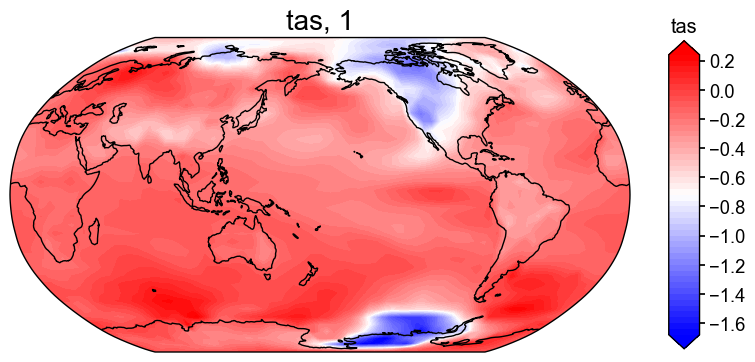

In [14]:
res.load(['tas', 'tas_gm', 'pr', 'pr_gm'])

# Create a basic plot
if 'tas' in res.recons:
    fig, ax = res.recons['tas'].plot(cmap='bwr')

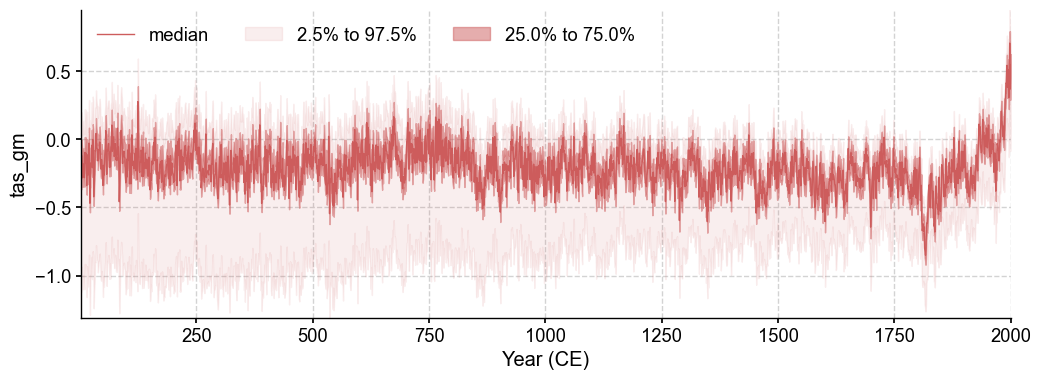

In [15]:
# Plot with ensemble spread
fig, ax = res.recons['tas_gm'].plot_qs()

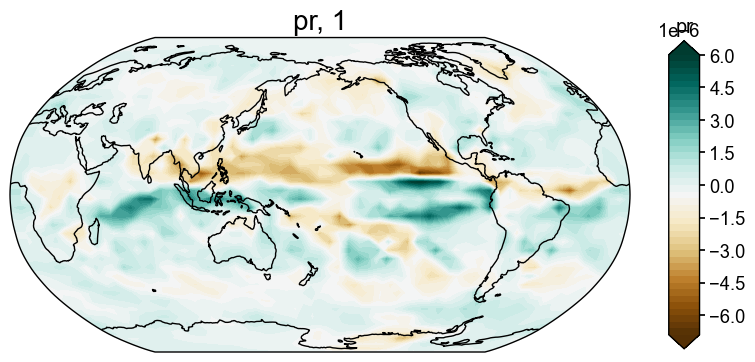

In [16]:
fig, ax = res.recons['pr'].plot()

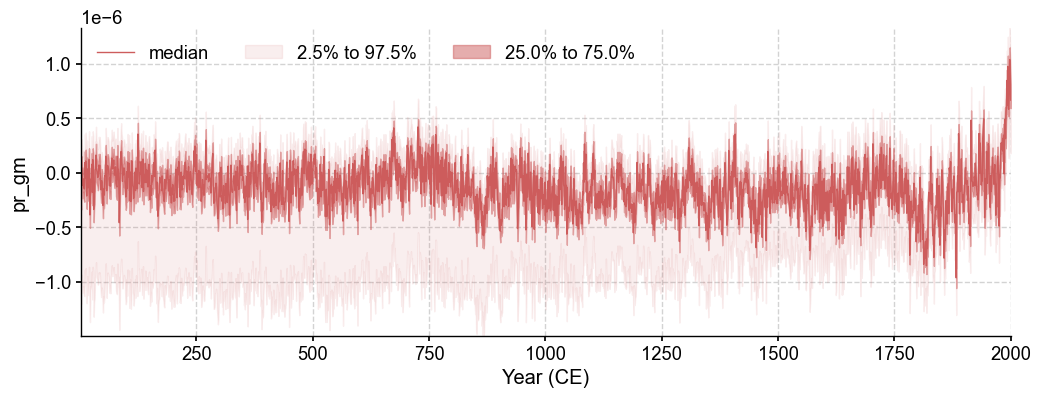

In [17]:
fig, ax = res.recons['pr_gm'].plot_qs()